In [1]:
import random
import numpy as np
from typing import List

In [2]:
import numpy as np
from tqdm import tqdm

class SchrodingerBridge:
    def __init__(self, distSize, nbpaths, timeSeriesData=None, dimension=None, timeSeriesDataVector=None):
        self.distSize = distSize
        self.nbpaths = nbpaths
        self.dimension = dimension

        if timeSeriesData is not None:
            self.timeSeriesData = np.array(timeSeriesData)
            self.timeSeries = np.zeros((distSize + 1,))
            self.timeSeries[0] = self.timeSeriesData[0, 0]
        else:
            self.timeSeriesData = None
            self.timeSeries = None

        if timeSeriesDataVector is not None:
            self.timeSeriesDataVector = np.array(timeSeriesDataVector)
            self.timeSeriesVector = np.zeros((distSize + 1, dimension))
        else:
            self.timeSeriesDataVector = None
            self.timeSeriesVector = None

        self.weights = np.zeros((nbpaths,))
        self.weights_tilde = np.zeros((nbpaths,))
    
    def __del__(self):
        pass

    def simulate_kernel(self, nbStepsPerDeltati, H, deltati):
        vtimestepEuler = np.arange(0, deltati + deltati/nbStepsPerDeltati, deltati/nbStepsPerDeltati)
        Brownian = np.random.normal(0, 1, self.distSize * (len(vtimestepEuler) - 1))

        timeSeries = np.zeros_like(self.timeSeries)
        timeSeries[0] = self.timeSeries[0]
        X_ = timeSeries[0]
        index_ = 0

        for interval in range(self.distSize):
            for particle in range(self.timeSeriesData.shape[0]):
                if interval == 0:
                    self.weights[particle] = 1.0 / self.nbpaths
                else:
                    self.weights[particle] *= self.kernel(self.timeSeriesData[particle, interval] - X_, H)

                self.weights_tilde[particle] = self.weights[particle] * np.exp((self.timeSeriesData[particle, interval + 1] - X_) ** 2 / (2.0 * deltati))

            for nbtime in range(len(vtimestepEuler) - 1):
                expecY = 0.0
                expecX = 0.0
                timeprev = vtimestepEuler[nbtime]
                timestep = vtimestepEuler[nbtime + 1] - vtimestepEuler[nbtime]

                for particle in range(self.timeSeriesData.shape[0]):
                    if nbtime == 0:
                        expecX += self.weights[particle]
                        expecY += self.weights[particle] * (self.timeSeriesData[particle, interval + 1] - X_)
                    else:
                        termtoadd = -(self.timeSeriesData[particle, interval + 1] - X_) ** 2 / (2.0 * (deltati - timeprev))
                        termtoadd = self.weights_tilde[particle] * np.exp(termtoadd)
                        expecX += termtoadd
                        expecY += termtoadd * (self.timeSeriesData[particle, interval + 1] - X_)

                drift = (1.0 / (deltati - timeprev)) * (expecY / expecX) if expecX > 0.0 else 0.0
                X_ += drift * timestep + Brownian[index_] * np.sqrt(timestep)
                index_ += 1

            timeSeries[interval + 1] = X_

        return timeSeries

    def simulate_kernel_vectorized(self, nbStepsPerDeltati, H, deltati):
        vtimestepEuler = np.arange(0, deltati + deltati/nbStepsPerDeltati, deltati/nbStepsPerDeltati)
        Brownian = np.random.normal(0, 1, self.distSize * self.dimension * (len(vtimestepEuler) - 1))

        X_ = np.zeros(self.dimension)
        index_ = 0

        for interval in range(self.distSize):
            for particle in range(self.timeSeriesDataVector.shape[0]):
                if interval == 0:
                    self.weights[particle] = 1.0 / self.nbpaths
                else:
                    for i in range(self.dimension):
                        self.weights[particle] *= self.kernel(self.timeSeriesDataVector[particle, interval, i] - X_[i], H)

                self.weights_tilde[particle] = self.weights[particle]
                for i in range(self.dimension):
                    self.weights_tilde[particle] *= np.exp((self.timeSeriesDataVector[particle, interval + 1, i] - X_[i]) ** 2 / (2.0 * deltati))

            for nbtime in range(len(vtimestepEuler) - 1):
                numerator = np.zeros(self.dimension)
                expecX = 0.0
                timeprev = vtimestepEuler[nbtime]
                timestep = vtimestepEuler[nbtime + 1] - vtimestepEuler[nbtime]

                for particle in range(self.timeSeriesDataVector.shape[0]):
                    if nbtime == 0:
                        expecX += self.weights[particle]
                        for i in range(self.dimension):
                            numerator[i] += self.weights[particle] * (self.timeSeriesDataVector[particle, interval + 1, i] - X_[i])
                    else:
                        termtoadd = 0.0
                        for i in range(self.dimension):
                            termtoadd += (self.timeSeriesDataVector[particle, interval + 1, i] - X_[i]) ** 2

                        termtoadd = self.weights_tilde[particle] * np.exp(-termtoadd / (2.0 * (deltati - timeprev)))
                        expecX += termtoadd

                        for i in range(self.dimension):
                            numerator[i] += termtoadd * (self.timeSeriesDataVector[particle, interval + 1, i] - X_[i])

                timestepsqrt = np.sqrt(timestep)
                for i in range(self.dimension):
                    drift = (1.0 / (deltati - timeprev)) * (numerator[i] / expecX) if expecX > 0.0 else 0.0
                    X_[i] += drift * timestep + Brownian[index_] * timestepsqrt
                    index_ += 1

            self.timeSeriesVector[interval + 1] = X_

        return self.timeSeriesVector

    @staticmethod
    def kernel(x, H):
        if abs(x) < H:
            return (H * H - x * x) ** 2
        else:
            return 0.0

    @staticmethod
    def schedule(timeEuler, maturity, timestep):
        time_ = 0.0
        while time_ < maturity:
            timeEuler.append(time_)
            time_ += timestep
        timeEuler.append(maturity)



In [3]:
# Example data
distSize = 10
nbpaths = 5
timeSeriesData = [[i + j for i in range(distSize + 1)] for j in range(nbpaths)]
dimension = 3
timeSeriesDataVector = [[[i + j + k for i in range(dimension)] for j in range(distSize + 1)] for k in range(nbpaths)]

# Instantiate the class
bridge = SchrodingerBridge(distSize, nbpaths, timeSeriesData=timeSeriesData)

# Simulate kernel
result = bridge.simulate_kernel(nbStepsPerDeltati=10, H=1.0, deltati=0.1)
print("Simulated Kernel:", result)

# Instantiate the class with vectorized data
bridge_vectorized = SchrodingerBridge(distSize, nbpaths, dimension=dimension, timeSeriesDataVector=timeSeriesDataVector)

# Simulate kernel vectorized
result_vectorized = bridge_vectorized.simulate_kernel_vectorized(nbStepsPerDeltati=10, H=1.0, deltati=0.1)
print("Simulated Kernel Vectorized:", result_vectorized)

Simulated Kernel: [ 0.          1.97508049  2.97748985  4.04303002  5.07035129  6.14071762
  7.01574798  7.90118764  9.03129885 10.02135868 10.97813537]
Simulated Kernel Vectorized: [[ 0.          0.          0.        ]
 [ 1.91595823  2.97294896  3.928178  ]
 [ 3.23115822  3.98400825  5.07034953]
 [ 3.93299496  4.96777281  6.10127437]
 [ 5.12475265  6.01861711  7.13624977]
 [ 5.94222472  7.0678272   8.056525  ]
 [ 7.15563581  8.01373322  9.01387291]
 [ 8.06066602  9.06545628  9.8839422 ]
 [ 8.95828225 10.02776361 11.10721378]
 [10.01008593 10.96638138 11.99244481]
 [11.06900376 12.08487072 13.01264492]]


In [4]:
import time
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
#from pandas_datareader import data as pdr
from datetime import date
from scipy.stats import ks_2samp, kstest, kurtosis
#import yfinance as yf
#yf.pdr_override()
#from fbm import FBM
#from tensorflow.keras.datasets import mnist
from pathlib import Path
import os
import warnings
warnings.filterwarnings("ignore")

In [5]:
def simulateSB(N, M, Data, deltati, H, nbStepsPerDeltati, numberOfSamples):
    assert Data.shape == (M, N+1)
    assert H > 0
    
    simulator = SchrodingerBridge(N, M, Data)

    simu = []
    for i in tqdm(range(numberOfSamples)):
        simu.append(simulator.simulate_kernel(nbStepsPerDeltati, H, deltati))
    simu = np.array(simu)
    
    return simu

## Toy autoregressive model of time series
1. SBTS diffusion

In [14]:
# Number of time steps and number of samples
M = 1000
N = 3

# Generate true time series
X = np.zeros((M, N+1))
X[:,0] = 0.
X[:,1] = np.random.normal(loc=0.7, scale=0.1, size=M)
X[:,2] = - X[:,1] + np.random.normal(scale=0.05, size=M)
X[:,3] = - X[:,2] + np.sqrt(X[:,1]) + np.random.normal(scale=0.05, size=M)

In [15]:
M, N, X.shape


(1000, 3, (1000, 4))

In [16]:
# Simulate
simu = simulateSB(
    N=N, 
    M=M,
    Data=X, 
    deltati=7./252., 
    H=0.05, 
    nbStepsPerDeltati=100, 
    numberOfSamples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Add simulated and true time series distributions to dataframe
df_data_SBTS = pd.DataFrame()
df_data_SBTS["X_1"] = X[:500,1].tolist() + simu[:500,1].tolist()
df_data_SBTS["X_2"] = X[:500,2].tolist() + simu[:500,2].tolist()
df_data_SBTS["X_3"] = X[:500,3].tolist() + simu[:500,3].tolist()
df_data_SBTS["type"] = ["Data"]*500 + ["SBTS"]*500

# Plot distribution
sns.set_style("whitegrid")
sns.set_style("white")

# Set pair
x = "X_1"
y = "X_3"

ax = sns.jointplot(
    data=df_data_SBTS,
    x=x, y=y, hue="type", ec='Navy', lw=2, alpha=1, palette="dark", kind="kde", fill=True
)
ax.set_axis_labels(r"$X_{t_1}$", r"$X_{t_3}$", fontsize=13)
ax.ax_joint.legend_.get_title().set_text("")
plt.setp(ax.ax_joint.legend_.get_texts(), fontsize=11)

plt.show()

In [ ]:
simu

In [ ]:
df_stats_quantiles = pd.DataFrame(
    columns=[
    "p-value", 
    "5%-quantile data", 
    "5%-quantile SB", 
    "95%-quantile data", 
    "95%-quantile SB"
    ],
    index=[1,2,3]
)

In [ ]:
for i in df_stats_quantiles.index:
    
    # Kolmogorov Smirnov test
    df_stats_quantiles['p-value'].loc[i] = kstest(rvs=X[:,i], cdf=simu[:,i])[1]
    
    # Quantiles
    df_stats_quantiles['5%-quantile data'].loc[i] = np.quantile(X[:,i], 0.05)
    df_stats_quantiles['95%-quantile data'].loc[i] = np.quantile(X[:,i], 0.95)
    df_stats_quantiles['5%-quantile SB'].loc[i] = np.quantile(simu[:,i], 0.05)
    df_stats_quantiles['95%-quantile SB'].loc[i] = np.quantile(simu[:,i], 0.95)

In [ ]:
df_stats_quantiles

In [ ]:
data_correlation_matrix = np.corrcoef(X[:,1:].T)
SB_correlation_matrix = np.corrcoef(simu[:,1:].T)

data_correlation_df = pd.DataFrame(data_correlation_matrix)
SB_correlation_df = pd.DataFrame(SB_correlation_matrix)
difference_df = pd.DataFrame((data_correlation_matrix - SB_correlation_matrix).round(3))

combined_df = pd.concat([data_correlation_df, SB_correlation_df, difference_df], axis=1)
print(combined_df.to_string())

## Garch Model
1. SBTS diffusion

In [ ]:
# Number of time steps and number of samples
M = 1000
N = 60

# Generate Garch time series
alpha_0 = 5.
alpha_1 =  0.4
alpha_2 = 0.1

def Garch_sample(alpha_0, alpha_1, alpha_2):
    
    time_series = list()
    x_next = 0.0
    x_prev = 0.0
    
    for t in range(N+50):
        
        # Diffuse over (for example) 50 time steps to achieve stationarity
        if t>=50:
            time_series.append(x_next)
        
        # Compute volatility
        sigma = np.sqrt(alpha_0 + alpha_1 * x_next**2 + alpha_2 * x_prev**2)
        x_prev = x_next
        x_next = sigma * np.random.normal(scale=0.1)
        
    return [0.0] + time_series

X = np.array([Garch_sample(alpha_0, alpha_1, alpha_2) for i in range(M)])

In [ ]:
M, N, X.shape

In [ ]:
simu = simulateSB(
    N = N, 
    M = M,
    Data = X, 
    deltati = 7./252., 
    H = 0.2, 
    nbStepsPerDeltati = 100, 
    numberOfSamples = 1000
)

In [ ]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Select random paths
for i in range(4):
    j = np.random.randint(len(simu))
    ax[0].plot(X[j], linewidth=1.5)
    ax[1].plot(simu[j], linewidth=1.5)
    
ax[0].axhline(0, linewidth=1, linestyle="--", color='k')
ax[0].set_xlabel('time')
ax[0].set_ylabel('Garch')
ax[0].set_ylim(-0.9, 0.9)
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].set_yticks([-0.8, -0.4, 0, 0.4, 0.8])

ax[1].axhline(0, linewidth=1, linestyle="--", color='k')
ax[1].set_xlabel('time')
ax[1].set_ylabel('SBTS')
ax[1].set_ylim(-0.9, 0.9)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].set_yticks([-0.8, -0.4, 0, 0.4, 0.8])

In [ ]:
!pip install tensorflow


In [6]:
from tensorflow.keras.datasets import mnist

# load dataset
(trainX, _), (_, _) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [7]:

M = 10000
N = 1
NbPixels = trainX.shape[1]
deltati = 1./252.

TimeSeries = np.zeros((M, N+1, NbPixels, NbPixels))
TimeSeries[:,1,:,:] = trainX[:M,:,:]/255/10 - 0.05 # Normalization to avoid numerical issues

In [8]:
TimeSeries.min(), TimeSeries.max()

(-0.05, 0.05)

In [19]:
TimeSeriesFlat = TimeSeries.reshape(M, N+1, -1)

TimeSeriesFlat.shape

(10000, 2, 784)

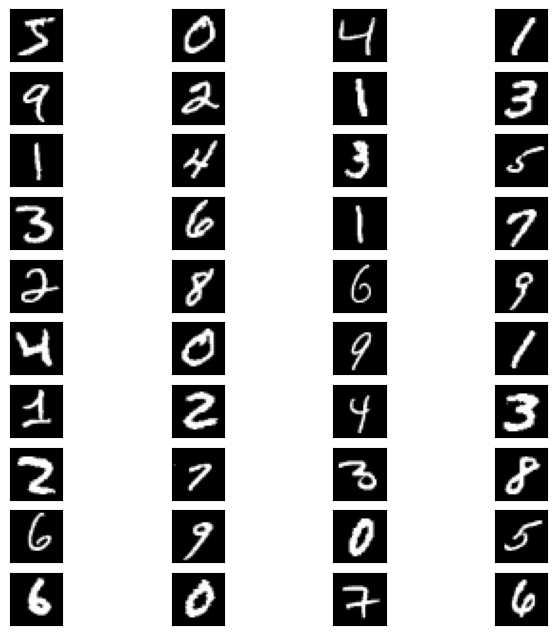

In [28]:
a= 10
b =4
fig, ax = plt.subplots(a, b, figsize=(8,8))

for i in range(a):
    for j in range(b):
        ax[i,j].imshow((TimeSeries[i*4 + j,1,:,:]+0.05)*10*255, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

In [52]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tqdm import tqdm

class RandomGenerator:
    def __init__(self):
        self.gen = np.random.default_rng()

    def gaussian_mt(self, gaussian):
        gaussian[:] = self.gen.normal(0, 1, size=len(gaussian))

    def uniform_mt(self, uniform):
        uniform[:] = self.gen.uniform(0, 1, size=len(uniform))

class SchrodingerBridge:
    def __init__(self, distSize, nbpaths, dimension, timeSeriesDataVector):
        self.distSize = distSize
        self.nbpaths = nbpaths
        self.dimension = dimension
        self.timeSeriesDataVector = np.array(timeSeriesDataVector)

        self.timeSeriesVector = np.zeros((distSize + 1, dimension))
        self.timeSeriesVector[0, :] = self.timeSeriesDataVector[0, 0, :]

        self.weights = np.zeros(nbpaths)
        self.weights_tilde = np.zeros(nbpaths)

    def kernel(self, x, H):
        if abs(x) < H:
            return (H * H - x * x) * (H * H - x * x)
        else:
            return 0.0

    def schedule(self, timeEuler, maturity, timestep):
        time_ = 0.0
        while time_ < maturity:
            timeEuler.append(time_)
            time_ += timestep
        timeEuler.append(maturity)

    def simulate_kernel_vectorized(self, nbStepsPerDeltati, H, deltati):
        vtimestepEuler = np.arange(0, deltati + deltati / nbStepsPerDeltati, deltati / nbStepsPerDeltati)
        Brownian = np.random.normal(0, 1, self.distSize * self.dimension * (len(vtimestepEuler) - 1))

        X_ = np.zeros(self.dimension)
        index_ = 0

        for interval in tqdm(range(self.distSize), desc="Intervals"):
            for particle in range(self.timeSeriesDataVector.shape[0]):
                if interval == 0:
                    self.weights[particle] = 1.0 / self.nbpaths
                else:
                    for i in range(self.dimension):
                        self.weights[particle] *= self.kernel(self.timeSeriesDataVector[particle, interval, i] - X_[i], H)

                self.weights_tilde[particle] = self.weights[particle]
                for i in range(self.dimension):
                    self.weights_tilde[particle] *= np.exp((self.timeSeriesDataVector[particle, interval + 1, i] - X_[i]) ** 2 / (2.0 * deltati))

            for nbtime in range(len(vtimestepEuler) - 1):
                numerator = np.zeros(self.dimension)
                expecX = 0.0
                timeprev = vtimestepEuler[nbtime]
                timestep = vtimestepEuler[nbtime + 1] - vtimestepEuler[nbtime]

                for particle in range(self.timeSeriesDataVector.shape[0]):
                    if nbtime == 0:
                        expecX += self.weights[particle]
                        for i in range(self.dimension):
                            numerator[i] += self.weights[particle] * (self.timeSeriesDataVector[particle, interval + 1, i] - X_[i])
                    else:
                        termtoadd = 0.0
                        for i in range(self.dimension):
                            termtoadd += (self.timeSeriesDataVector[particle, interval + 1, i] - X_[i]) ** 2

                        termtoadd = self.weights_tilde[particle] * np.exp(-termtoadd / (2.0 * (deltati - timeprev)))
                        expecX += termtoadd

                        for i in range(self.dimension):
                            numerator[i] += termtoadd * (self.timeSeriesDataVector[particle, interval + 1, i] - X_[i])

                timestepsqrt = np.sqrt(timestep)
                for i in range(self.dimension):
                    drift = (1.0 / (deltati - timeprev)) * (numerator[i] / expecX) if expecX > 0.0 else 0.0
                    X_[i] += drift * timestep + Brownian[index_] * timestepsqrt
                    index_ += 1

            self.timeSeriesVector[interval + 1] = X_

        return self.timeSeriesVector

In [ ]:

TimeSeriesFlat = TimeSeries.reshape(M, N+1, -1)
numberOfSamples = 16 #perfect square 

simulator = SchrodingerBridge(N, M, NbPixels**2, TimeSeriesFlat)
simuTimeSeriesFlat = np.empty((numberOfSamples, N+1, NbPixels**2))
for i in tqdm(range(numberOfSamples)):
    images = np.array(simulator.simulate_kernel_vectorized(50, 1.1, 1./252.))
    simuTimeSeriesFlat[i] = images

simuTimeSeries = simuTimeSeriesFlat.reshape(numberOfSamples, N+1, NbPixels, NbPixels)

Intervals:   0%|                                                                                 | 0/1 [00:00<?, ?it/s]

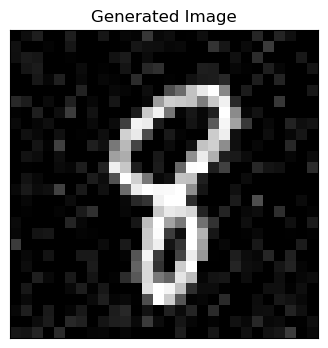

In [51]:
# Visualize the generated image
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
random_index = np.random.randint(0, numberOfSamples)
ax.imshow((simuTimeSeries[random_index, 1, :, :] + 0.05) * 10 * 255, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
ax.set_xticks([])
ax.set_yticks([])
plt.title('Generated Image')
plt.show()

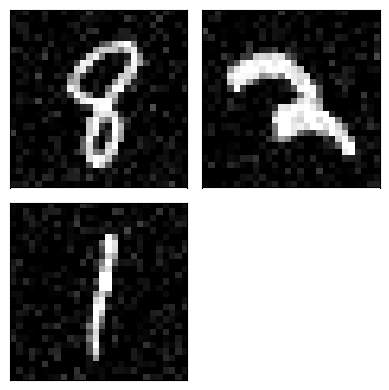

In [38]:
# Plotting the results
if numberOfSamples == 1:
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow((simuTimeSeries[0, 1, :, :] + 0.05) * 10 * 255, cmap='gray', vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title('Generated Image')
    plt.show()
else:
    rows = int(np.ceil(np.sqrt(numberOfSamples)))
    cols = int(np.ceil(numberOfSamples / rows))
    fig, ax = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    ax = ax.flatten() if numberOfSamples > 1 else [ax]
    for i in range(numberOfSamples):
        ax[i].imshow((simuTimeSeries[i, 1, :, :] + 0.05) * 10 * 255, cmap='gray', vmin=0, vmax=255)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    for i in range(numberOfSamples, len(ax)):
        fig.delaxes(ax[i])
    plt.tight_layout()
    plt.show()